In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')

In [46]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of data')

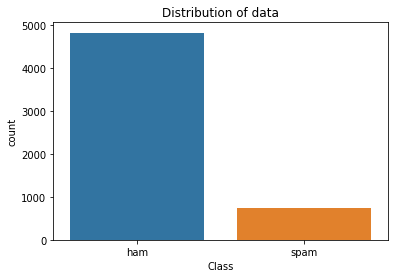

In [47]:
fig, ax = plt.subplots()
sns.countplot(df.v1, ax=ax)
ax.set_xlabel('Class')
ax.set_title('Distribution of data')

In [48]:
X = df.loc[:, 'v2']
y = df.loc[:, 'v1']

X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(4457,)
(1115,)


In [50]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

220



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


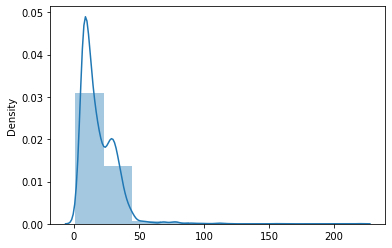

In [51]:
sent_lens = []
for sent in X_train:
    sent_lens.append(len(word_tokenize(sent)))
    
print(max(sent_lens))
print()

sns.distplot(sent_lens, bins=10, kde=True)

In [52]:
np.quantile(sent_lens, 0.95)

39.0

In [53]:
max_sequence_length = 39

tok = Tokenizer()
tok.fit_on_texts(X_train.values)

vocab_length = len(tok.word_index)
print('No. of unique tokens(vocab_size): ', vocab_length)

X_train_sequences = tok.texts_to_sequences(X_train.values)
X_test_sequences = tok.texts_to_sequences(X_test.values)
print('No of sequences:', len(X_train_sequences))

X_train = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
X_train[:2]

No. of unique tokens(vocab_size):  7954
No of sequences: 4457


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   38,   30,
           8,    5,  273, 1989,   81,  116,   26,   11, 1656,  322,   10,
          53,   18,  299,   30,  349, 1990],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  799,   15, 2555, 1442, 1127,  192,
        2556,  171,   12,   98, 1991,   44,  195, 1657, 2557, 1992, 2558,
          21,    9,    4,  203, 1025,  225]], dtype=int32)

In [54]:
print(y_train.values)

le = LabelEncoder()
train_labels = le.fit_transform(y_train)
test_labels = le.fit_transform(y_test)
print(train_labels)

['ham' 'spam' 'ham' ... 'ham' 'ham' 'ham']
[0 1 0 ... 0 0 0]


In [55]:
def create_model(vocab_len, max_seq_len):
    inputs = Input(name='inputs', shape=[max_seq_len])
    layer = Embedding(vocab_length + 1, 50, input_length=max_seq_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['acc'])
    return model

model = create_model(vocab_length, max_sequence_length)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 39)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 39, 50)            397750    
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257 

In [56]:
filepath='model_with_best_weights.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, verbose=1),]

history = model.fit(X_train, train_labels, batch_size=128, epochs=20, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.3195 - acc: 0.8729
Epoch 1: val_loss improved from inf to 0.15277, saving model to model_with_best_weights.h5
28/28 [==============================] - 7s 100ms/step - loss: 0.3195 - acc: 0.8729 - val_loss: 0.1528 - val_acc: 0.9585
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.0893 - acc: 0.9787
Epoch 2: val_loss improved from 0.15277 to 0.05509, saving model to model_with_best_weights.h5
28/28 [==============================] - 2s 78ms/step - loss: 0.0893 - acc: 0.9787 - val_loss: 0.0551 - val_acc: 0.9809
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.0333 - acc: 0.9910
Epoch 3: val_loss did not improve from 0.05509
28/28 [==============================] - 2s 76ms/step - loss: 0.0333 - acc: 0.9910 - val_loss: 0.0608 - val_acc: 0.9821
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.9952
Epoch 4: val_loss improved from 0.05509 to 0.04632

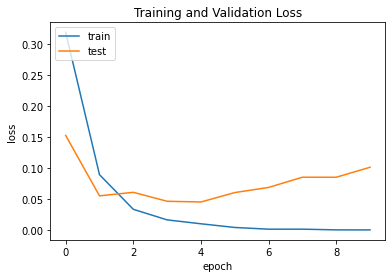

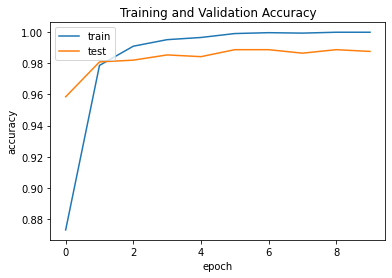

In [57]:
history_dict = history.history

plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_dict['acc'])
plt.plot(history_dict['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
loaded_model = load_model('model_with_best_weights.h5')
test_loss, test_acc = accr = loaded_model.evaluate(X_test, test_labels)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_acc))

35/35 [==============================] - 1s 7ms/step - loss: 0.0520 - acc: 0.9857
Test set
  Loss: 0.052
  Accuracy: 0.986


In [59]:
y_pred_proba = loaded_model.predict(X_test)

print(np.round(y_pred_proba, 3))

y_pred = y_pred_proba > 0.5
y_pred

35/35 [==============================] - 1s 8ms/step
[[0.911]
 [0.002]
 [0.991]
 ...
 [0.001]
 [0.002]
 [0.998]]


array([[ True],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])